In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from glob import glob

from tqdm import tqdm

mpl.rcParams['figure.figsize'] = (8, 6)

print(tf.__version__)

2.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving methods.py to methods.py


In [ ]:
from methods import *

In [ ]:
simulations_path = '/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/RMS_FULL_26_Processed'
bin_path = '/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/bin_calc'
data_path = '/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/bin'

In [ ]:
files = glob(simulations_path +"/26*.csv")

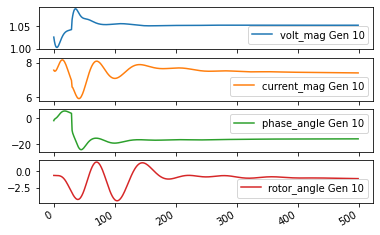

In [ ]:
df_plot = pd.read_csv(next(iter(files)), index_col=0)
plot_cols = ['volt_mag Gen 10',  'current_mag Gen 10', 'phase_angle Gen 10', 'rotor_angle Gen 10']
plot_features = df_plot[plot_cols]
plot_features.index = df_plot.index.values
_= plot_features.plot(subplots=True)

In [ ]:
#getting column names and file shapes
columns = pd.read_csv(next(iter(files)), index_col=0)
columns = columns.iloc[:, 2:]
n_rows = columns.shape[0]
n_cols = columns.shape[1]
columns = columns.columns
print(next(iter(files)))
print(columns)
print("Number of rows: " + str(n_rows))
print("Number of columns: " + str(n_cols))

/content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/RMS_FULL_26_Processed/26%_wind_Line 27-28_clearing-0.3_load-0.8_inertia-2.33_spinreserve-2696.0_.csv
Index(['volt_mag Gen 10', 'volt_mag Gen 12', 'volt_mag Gen 25',
       'volt_mag Gen 26', 'volt_mag Gen 31', 'volt_mag Gen 46',
       'volt_mag Gen 49', 'volt_mag Gen 54', 'volt_mag Gen 59',
       'volt_mag Gen 61', 'volt_mag Gen 65', 'volt_mag Gen 66',
       'volt_mag Gen 69', 'volt_mag Gen 87', 'volt_mag Gen 100',
       'current_mag Gen 10', 'current_mag Gen 12', 'current_mag Gen 25',
       'current_mag Gen 26', 'current_mag Gen 31', 'current_mag Gen 46',
       'current_mag Gen 49', 'current_mag Gen 54', 'current_mag Gen 59',
       'current_mag Gen 61', 'current_mag Gen 65', 'current_mag Gen 66',
       'current_mag Gen 69', 'current_mag Gen 87', 'current_mag Gen 100',
       'phase_angle Gen 10', 'phase_angle Gen 12', 'phase_angle Gen 25',
       'phase_angle Gen 26', 'phase_angle Gen 31', 'phase_angle Gen 46',


In [ ]:
data = np.load(data_path + '/data.npy')

In [ ]:
#splitting the data into train, validation and test sets 70%, 20%, 10%
split_index = len(data)

train = data[0:int(split_index*0.7)]
val = data[int(split_index*0.7):int(split_index*0.9)]
test = data[int(split_index*0.9):]

print("train_df has shape: " + str(train.shape))
print("val_df has shape: " + str(val.shape))
print("test_df has shape: " + str(test.shape))

train_df has shape: (839, 500, 59)
val_df has shape: (240, 500, 59)
test_df has shape: (120, 500, 59)


In [ ]:
#normalising the data, from methods.py - normalise
train_df, val_df, test_df = normalise_zero_mean(train, val, test)

In [ ]:
#getting feature/label column and and indices
FEATURE_COLUMNS, FEATURE_COLUMN_INDICES = get_feature_or_label_columns_and_indices(columns, None, end_index=45)
LABEL_COLUMNS, LABEL_COLUMN_INDICES = get_feature_or_label_columns_and_indices(columns, 45, end_index=None)

In [ ]:
start_index=0
end_index=None
look_back=30
look_forward=20
step=1

X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

for simulation in tqdm(range(len(train_df))):
  x_train, y_train = get_window(train_df[simulation], start_index, look_back, look_forward,
                      step, columns, end_index=None, feature_columns=FEATURE_COLUMNS, 
                      label_columns=LABEL_COLUMNS)
  
  X_train.append(x_train)
  Y_train.append(y_train)

for simulation in tqdm(range(len(val_df))):
  x_val, y_val = get_window(val_df[simulation], start_index, look_back, look_forward,
                      step, columns, end_index=None, feature_columns=FEATURE_COLUMNS, 
                      label_columns=LABEL_COLUMNS)
  
  X_val.append(x_val)
  Y_val.append(y_val)

for simulation in tqdm(range(len(test_df))):
  x_test, y_test = get_window(test_df[simulation], start_index, look_back, look_forward,
                      step, columns, end_index=None, feature_columns=FEATURE_COLUMNS, 
                      label_columns=LABEL_COLUMNS)
  
  X_test.append(x_test)
  Y_test.append(y_test)

X_train = np.concatenate(X_train)
Y_train = np.concatenate(Y_train)
X_val = np.concatenate(X_val)
Y_val = np.concatenate(Y_val)
X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)

print("X_train shape is: " +str(X_train.shape))
print("Y_train shape is: " +str(Y_train.shape))
print("X_val shape is: " +str(X_val.shape))
print("Y_val shape is: " +str(Y_val.shape))
print("X_test shape is: " +str(X_test.shape))
print("Y_test shape is: " +str(Y_test.shape))

100%|██████████| 120/120 [00:04<00:00, 25.34it/s]


X_train shape is: (377550, 30, 45)
Y_train shape is: (377550, 20, 14)
X_val shape is: (108000, 30, 45)
Y_val shape is: (108000, 20, 14)
X_test shape is: (54000, 30, 45)
Y_test shape is: (54000, 20, 14)


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16

train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

train_auto_encoder = tf.data.Dataset.from_tensor_slices((X_train, X_train))
train_auto_encoder = train_auto_encoder.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_auto_encoder = tf.data.Dataset.from_tensor_slices((X_val, X_val))
val_auto_encoder = val_auto_encoder.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val = val.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test = test.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [ ]:
print(train.element_spec)
print(train_auto_encoder.element_spec)
print(val_auto_encoder.element_spec)
print(val.element_spec)
print(test.element_spec)

(TensorSpec(shape=(None, 30, 45), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 14), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 30, 45), dtype=tf.float64, name=None), TensorSpec(shape=(None, 30, 45), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 30, 45), dtype=tf.float64, name=None), TensorSpec(shape=(None, 30, 45), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 30, 45), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 14), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 30, 45), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 14), dtype=tf.float64, name=None))


In [ ]:
for example_inputs, example_labels in train.take(1):
  print(f'Train inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Train labels shape (batch, time, features): {example_labels.shape}')
  print('\n')
for example_inputs, example_labels in val.take(1):
  print(f'Validation inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Validation labels shape (batch, time, features): {example_labels.shape}')
  print('\n')
for example_inputs, example_labels in test.take(1):
  print(f'Test inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Test labels shape (batch, time, features): {example_labels.shape}')

Train inputs shape (batch, time, features): (16, 30, 45)
Train labels shape (batch, time, features): (16, 20, 14)


Validation inputs shape (batch, time, features): (16, 30, 45)
Validation labels shape (batch, time, features): (16, 20, 14)


Test inputs shape (batch, time, features): (16, 30, 45)
Test labels shape (batch, time, features): (16, 20, 14)


## ML Models

In [ ]:
MAX_EPOCHS = 20
num_features = x_train.shape[2]
training_samples = X_train.shape[0]
validation_samples = X_val.shape[0]
test_samples = X_test.shape[0]
STEPS_PER_EPOCH = training_samples//BATCH_SIZE
VALIDATION_STEPS = validation_samples//BATCH_SIZE
TEST_STEPS = test_samples//BATCH_SIZE
num_labels=14

In [ ]:
multi_val_performance = {}
multi_performance = {}

## Linear Model

3375/3375 [==============================] - 3s 774us/step - loss: 0.3183 - mean_absolute_error: 0.3183


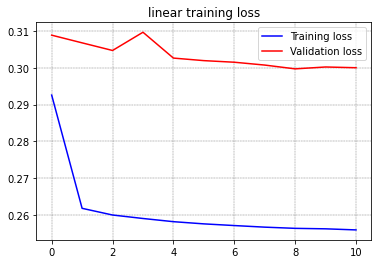

In [ ]:
#linear model
linear_model = tf.keras.Sequential([
  # Shape [batch, time, features] => [batch, 1, features]
  tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
  tf.keras.layers.Dense(look_forward*num_labels,
                        kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([look_forward, num_labels])
])

history_linear = compile_and_fit(linear_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS)
#linear_model.save(bin_path + '/linear_model')

IPython.display.clear_output()
multi_val_performance['Linear'] = linear_model.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['Linear'] = linear_model.evaluate(test, steps=TEST_STEPS)

plot_train_history(history_linear, 'linear training loss')

In [ ]:
linear_plot = tf.keras.models.load_model(bin_path+'/linear_model') 

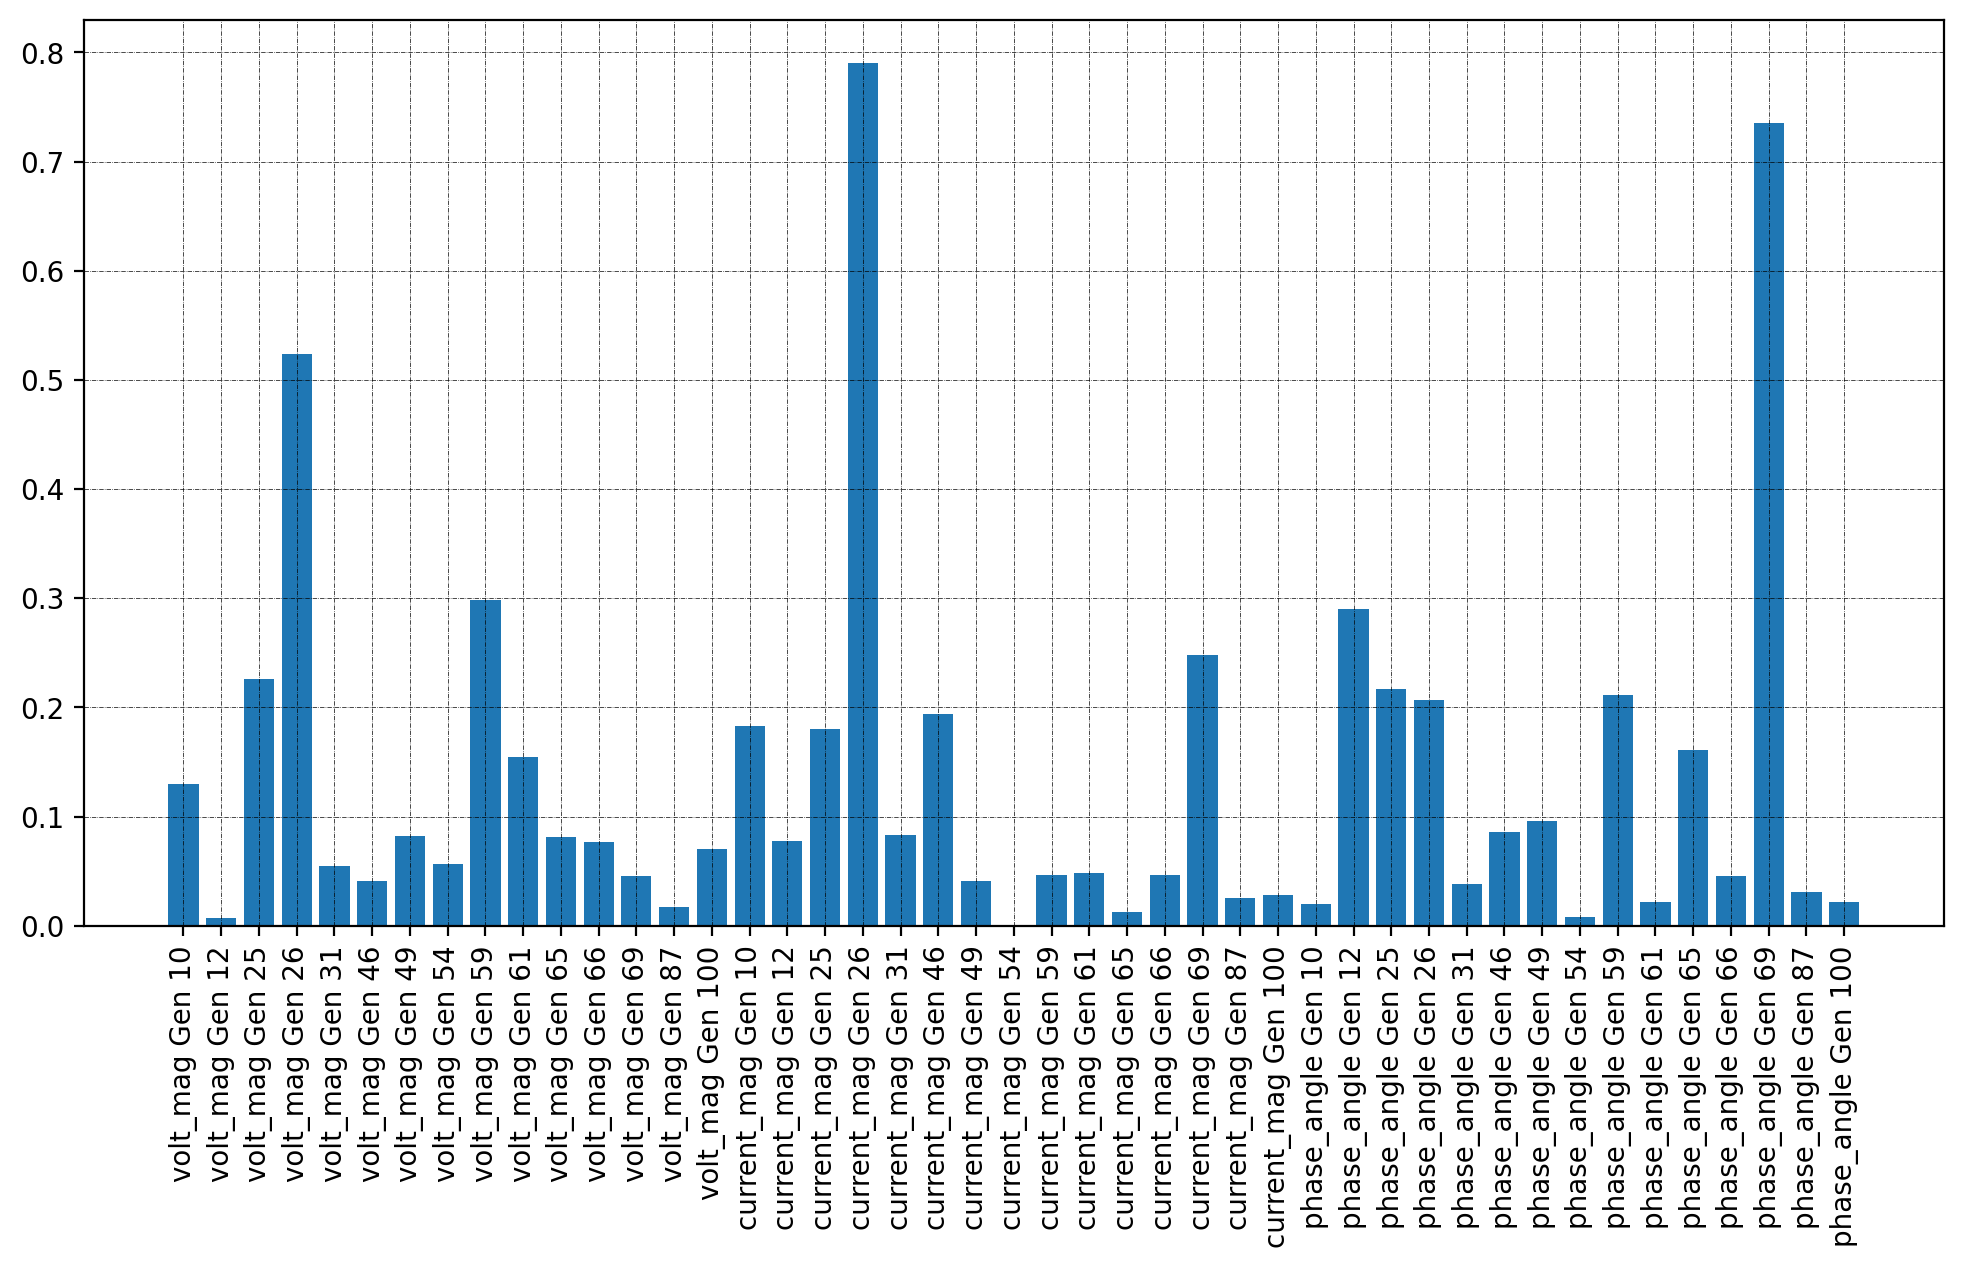

In [ ]:
#plotting linear model weights gen 26
#weights obtained my optimising for MEAN SQUARED ERROR
plt.figure(figsize=(12, 6), dpi=200)
plt.grid(color='k', ls = '-.', lw = 0.25)
plt.bar(x = range(len(feature_columns_indices)),
        height=np.abs(linear_model.layers[1].kernel[:,3].numpy()))
axis = plt.gca()
axis.set_xticks(range(len(feature_columns_indices)))
_ = axis.set_xticklabels(columns, rotation=90)

## Linear model with added dense layer

3375/3375 [==============================] - 6s 2ms/step - loss: 0.1398 - mean_absolute_error: 0.1398


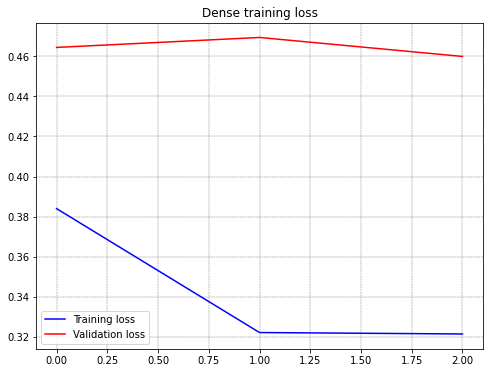

In [ ]:
#adding single dense layer to simple linear model
dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(look_forward*num_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, look_forward, num_features]
    tf.keras.layers.Reshape([look_forward, num_labels])
])

dense_history = compile_and_fit(dense_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS)
dense_model.save(bin_path + '/single_dense')

IPython.display.clear_output()
multi_val_performance['Dense'] = dense_model.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['Dense'] = dense_model.evaluate(test, steps=TEST_STEPS)

plot_train_history(history_linear, 'Dense training loss')

## Dense layer and single convolution

3375/3375 [==============================] - 6s 2ms/step - loss: 0.1425 - mean_absolute_error: 0.1425


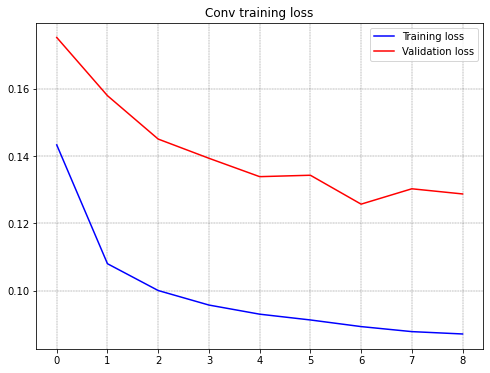

In [ ]:
CONV_WIDTH = 5
conv_model = tf.keras.Sequential([
  # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
  tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
  tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
  tf.keras.layers.Dense(look_forward*num_labels,
                        kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([look_forward, num_labels])
])

conv_history = compile_and_fit(conv_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS)
conv_model.save(bin_path + '/conv_model')

IPython.display.clear_output()

multi_val_performance['Conv'] = conv_model.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['Conv'] = conv_model.evaluate(test, steps=TEST_STEPS)
plot_train_history(conv_history, 'Conv training loss')

## LSTM Model

## Finding a good learning late with learning rate scheduler 

In [ ]:
lstm_model = tf.keras.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=False),
  tf.keras.layers.Dense(look_forward*num_labels,
                        kernel_initializer=tf.initializers.glorot_normal()),
  tf.keras.layers.Reshape([look_forward, num_labels])
])

history_lstm = learning_rate_scheduler(lstm_model, train, STEPS_PER_EPOCH)
IPython.display.clear_output()

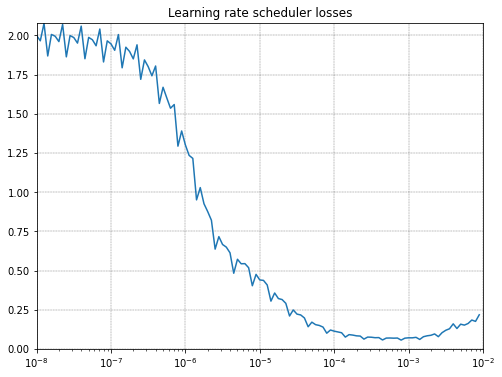

In [ ]:
plt.semilogx(history_lstm.history["lr"], history_lstm.history["loss"])
plt.axis([1e-8 * 10**(0 / 20), 1e-8 * 10**(120 / 20), 0, 2.08])
plt.grid(color='k', ls = '-.', lw = 0.25)
plt.title("Learning rate scheduler losses")
plt.show()

3375/3375 [==============================] - 7s 2ms/step - loss: 0.0717 - mean_absolute_error: 0.0717


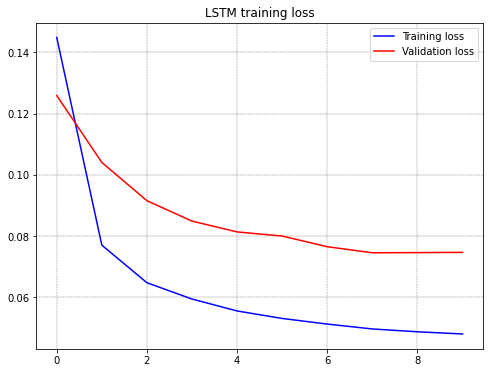

In [ ]:
lstm_model = tf.keras.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=False),
  tf.keras.layers.Dense(look_forward*num_labels,
                        kernel_initializer=tf.initializers.glorot_normal()),
  tf.keras.layers.Reshape([look_forward, num_labels])
])

history_lstm = compile_and_fit(lstm_model, train, val, STEPS_PER_EPOCH,
                                 VALIDATION_STEPS, MAX_EPOCHS, learning_rate=9e-4)
lstm_model.save(bin_path + '/single_lstm_model')

IPython.display.clear_output()

multi_val_performance['LSTM'] = lstm_model.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['LSTM'] = lstm_model.evaluate(test, steps=TEST_STEPS)
plot_train_history(history_lstm, 'LSTM training loss')

## Bidirectional LSTM

3375/3375 [==============================] - 10s 3ms/step - loss: 0.0642 - mean_absolute_error: 0.0642


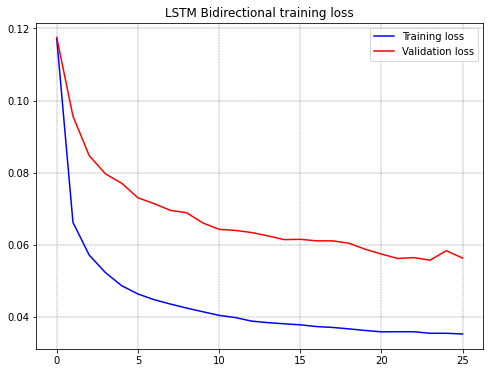

In [ ]:
lstm_model_bidirectional = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
  tf.keras.layers.Dense(look_forward*num_labels,
                        kernel_initializer=tf.initializers.glorot_normal()),
  tf.keras.layers.Reshape([look_forward, num_labels])
])

history_lstm_bidirectional = compile_and_fit(lstm_model_bidirectional, train, 
                                             val, STEPS_PER_EPOCH, 
                                             VALIDATION_STEPS, MAX_EPOCHS, 
                                             learning_rate=9e-4)
lstm_model_bidirectional.save(bin_path + '/single_lstm_bidirectional_model')

IPython.display.clear_output()

multi_val_performance['Bi-LSTM'] = lstm_model_bidirectional.evaluate(val, steps=VALIDATION_STEPS)
multi_performance['Bi-LSTM'] = lstm_model_bidirectional.evaluate(test, steps=TEST_STEPS)
plot_train_history(history_lstm_bidirectional, 'LSTM Bidirectional training loss')

In [ ]:
# Save
np.save(bin_path + '/val_results.npy', multi_val_performance) 
np.save(bin_path + '/test_results.npy', multi_performance) 

In [ ]:
# Load
#dict = np.load('my_file.npy',allow_pickle='TRUE').item()

## Autoencoder

In [ ]:
#simple autoencoder bidirectiional

lstm_encoder_bi = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), input_shape=[None, len(FEATURE_COLUMNS)]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30))
])

lstm_decoder_bi = tf.keras.Sequential([
  tf.keras.layers.RepeatVector(look_back, input_shape=[60]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(FEATURE_COLUMNS)))
])

lstm_autoencoder_bi = tf.keras.Sequential([lstm_encoder_bi, lstm_decoder_bi])

history_autoencoder = compile_and_fit(lstm_autoencoder_bi, , train, val, STEPS_PER_EPOCH,
                                      VALIDATION_STEPS, MAX_EPOCHS,
                                      learning_rate=9e-4)
lstm_autoencoder_bi.save(bin_path + '/autoencoder')

IPython.display.clear_output()

lstm_autoencoder_bi.evaluate(val_auto_encoder, steps=VALIDATION_STEPS)
plot_train_history(history_autoencoder, 'Autoencoder training loss')

6750/6750 [==============================] - 43s 6ms/step - loss: 0.0527 - mean_absolute_error: 0.0527


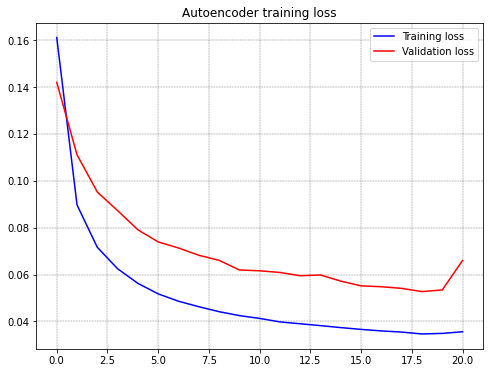

In [ ]:
lstm_autoencoder_bi.evaluate(val_auto_encoder, steps=VALIDATION_STEPS)
plot_train_history(history_autoencoder, 'Autoencoder training loss')

In [ ]:
##retraining autoencoder with lower learning rate
autoencoder_retrain = tf.keras.models.load_model(bin_path+'/autoencoder')


history_autoencoder_retrain = compile_and_fit(autoencoder_retrain, train, val, 
                                              STEPS_PER_EPOCH, VALIDATION_STEPS, 
                                              MAX_EPOCHSlearning_rate=1e-5, 
                                              checkpoint_filepath=bin_path + '/autoencoder')

autoencoder_retrain.save(bin_path + '/autoencoder_retrain')

IPython.display.clear_output()

autoencoder_retrain.evaluate(val_auto_encoder, steps=VALIDATION_STEPS)
plot_train_history(history_autoencoder_retrain, 'Autoencoder training loss')


## Endoder/decoder model


In [ ]:
# Load results
multi_val_performance = np.load(bin_path+'/val_results.npy',allow_pickle='TRUE').item()
multi_performance = np.load(bin_path+'/test_results.npy',allow_pickle='TRUE').item()

3375/3375 [==============================] - 27s 8ms/step - loss: 0.0471 - mean_absolute_error: 0.0471


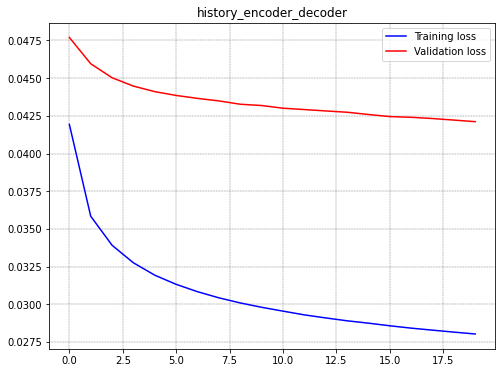

In [ ]:
autoencoder = tf.keras.models.load_model(bin_path+'/autoencoder_retrain')
autoencoder_decoder_best = tf.keras.models.load_model(bin_path+'/encoder_decoder_best')

encoder = autoencoder.layers[0]

decoder = tf.keras.Sequential([
  tf.keras.layers.RepeatVector(look_back, input_shape=[60]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)), 
  tf.keras.layers.Dense(look_forward*num_labels,
                        kernel_initializer=tf.initializers.glorot_normal()),
  tf.keras.layers.Reshape([look_forward, num_labels])
], name = 'decoder')

encoder_decoder = tf.keras.Sequential([encoder, decoder])
encoder_decoder.layers[0].trainable = False
encoder_decoder.layers[1].set_weights(autoencoder_decoder_best.layers[1].get_weights()) 

history_encoder_decoder = compile_and_fit(encoder_decoder, train, val, 
                                          STEPS_PER_EPOCH, VALIDATION_STEPS, 
                                          MAX_EPOCHSlearning_rate=1e-5)
#encoder_decoder.save(bin_path + '/encoder_decoder')

IPython.display.clear_output()

encoder_decoder.evaluate(val, steps=VALIDATION_STEPS)
encoder_decoder.evaluate(test, steps=TEST_STEPS)
plot_train_history(history_encoder_decoder, 'history_encoder_decoder')

In [ ]:
encoder_decoder.save(bin_path + '/encoder_decoder_best_2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/powerfactory_files/RMS_FULL_26_Processed/bin_calc/encoder_decoder_best_2/assets


## Plotting distrubution of predictions

In [ ]:
encoder_decoder = tf.keras.models.load_model(bin_path+'/encoder_decoder_best_2')

In [ ]:
encoder_decoder.evaluate(test, steps=TEST_STEPS)

3375/3375 [==============================] - 57s 17ms/step - loss: 0.0471 - mean_absolute_error: 0.0471


[0.04714098945260048, 0.04714096337556839]

In [ ]:
evals = np.array([])

for x, y in tqdm(test.take(TEST_STEPS)):
    eval = encoder_decoder.evaluate(x, y, verbose=0)
    evals = np.append(evals, eval[1])

100%|██████████| 3375/3375 [03:12<00:00, 17.51it/s]


In [ ]:
evals_mean = evals.mean()
evals_std = evals.std()
evals_median = np.median(evals)

print(evals_mean)
print(evals_std)
print(evals_median)

0.04714095417824057
0.042846919284535885
0.03628893569111824


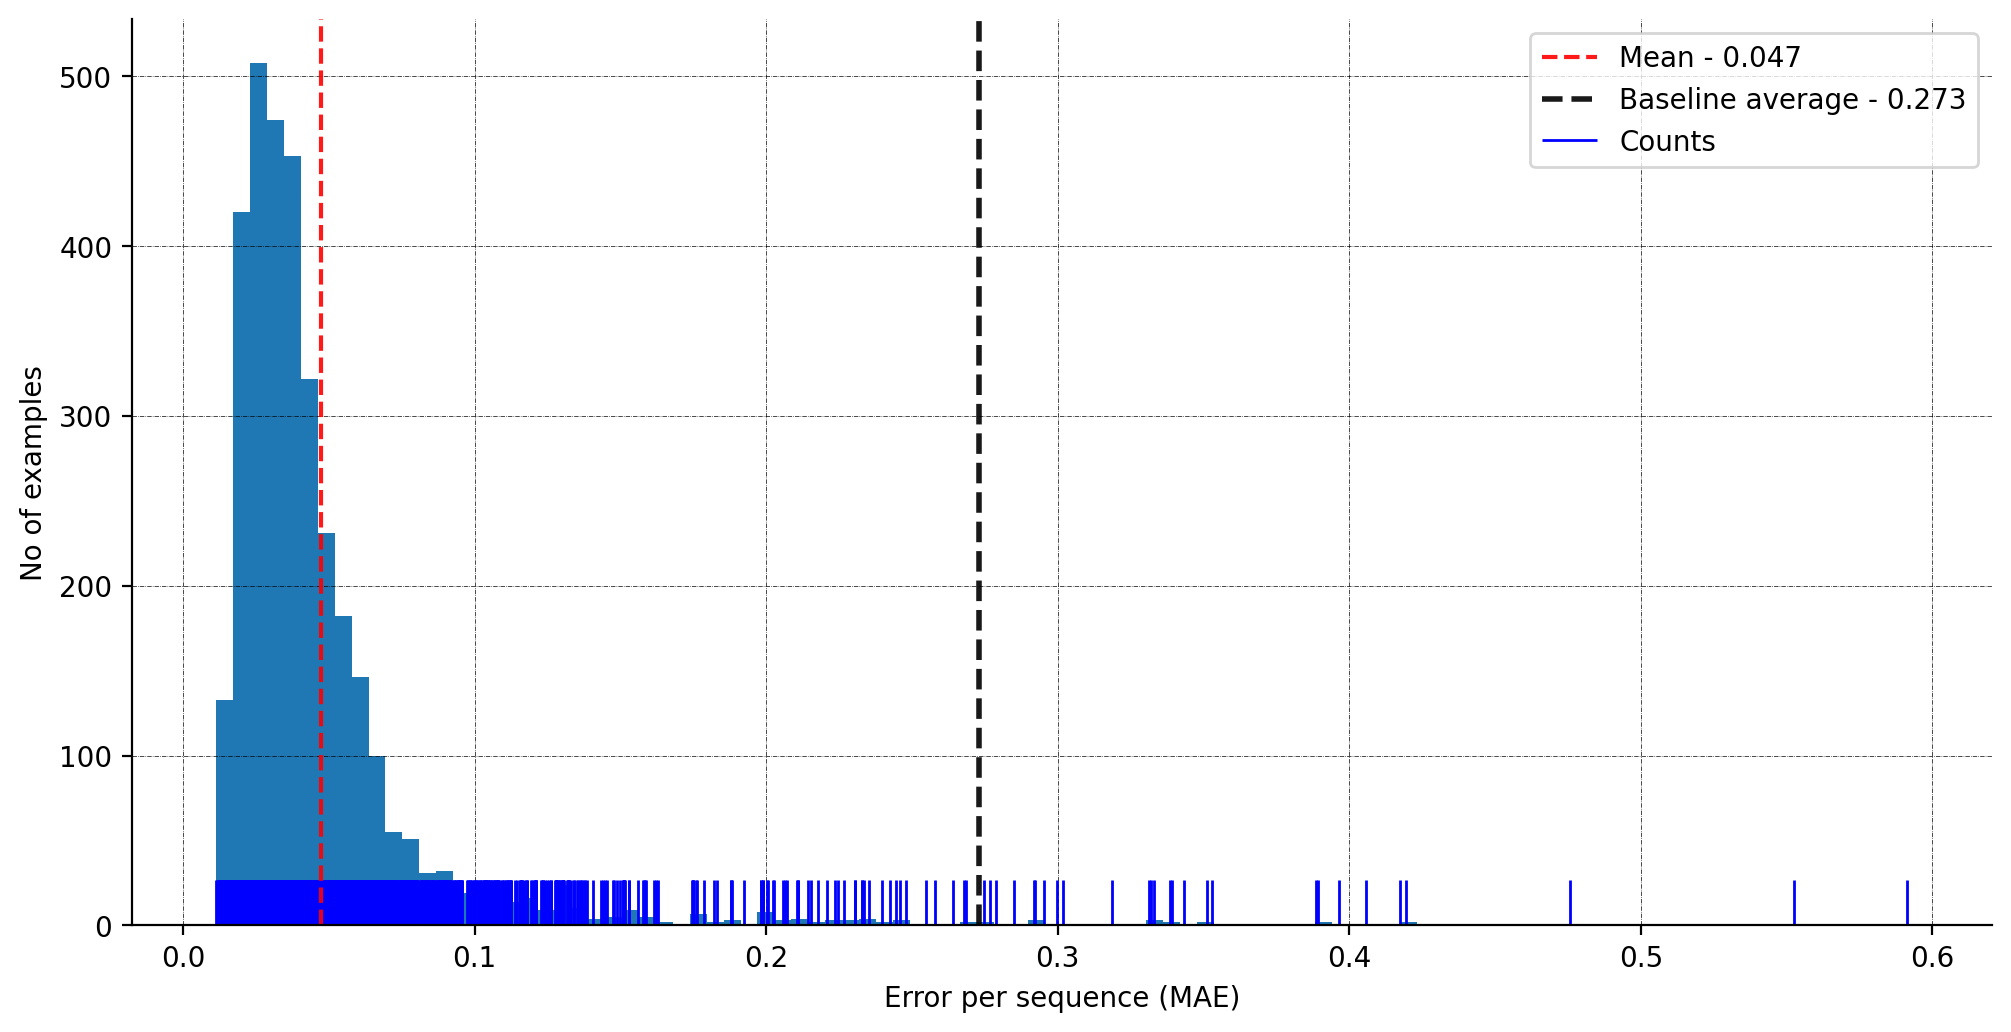

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
ax.hist(evals, bins=100)
plt.xlabel("Error per sequence (MAE)")
sns.distplot(evals, rug=True, hist=False, bins=100, kde=False, label='Counts', color='blue')
plt.ylabel("No of examples")
ax.axvline(evals_mean, ls='--', c='r', alpha=0.9, label='Mean - ' + str(round(evals_mean, 3)))
ax.axvline(0.273, ls='--', c='k', alpha=0.9, label='Baseline average - 0.273', linewidth=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(color='k', ls = '-.', lw = 0.25)
plt.legend()
plt.show()

## Training encoder/decoder with Monte Carlo dropout - dropout probability 0.2

In [ ]:
encoder_decoder_dropout_trained = tf.keras.models.load_model(bin_path+'/encoder_decoder_dropout_0.2')
encoder_trained = encoder_decoder_dropout_trained.layers[0]

In [ ]:
input= keras.Input(shape=(60))
x = layers.RepeatVector(30, input_shape=[60])(input)
x = layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2, 
                                                    recurrent_dropout=0.2,
                                                     return_sequences=False))(x)
x = layers.Dense(look_forward*num_labels,
                        kernel_initializer=tf.initializers.glorot_normal())(x)
output = layers.Reshape([look_forward, num_labels])(x)

decoder_dropout = keras.Model(input, output, name="decoder_dropout")

In [ ]:
encoder_decoder_dropout = tf.keras.Sequential([encoder_trained, decoder_dropout])
encoder_decoder_dropout.set_weights(encoder_decoder_dropout_trained.get_weights()) 
encoder_decoder_dropout.layers[0].trainable = False

In [ ]:
history_encoder_decoder_dropout = compile_and_fit(encoder_decoder_dropout, train, 
                                                  val, STEPS_PER_EPOCH, 
                                                  VALIDATION_STEPS, MAX_EPOCHS, 
                                                  learning_rate=5e-6, 
                                                  checkpoint_filepath=bin_path + '/encoder_decoder_dropout_0.2')
encoder_decoder_dropout.save(bin_path + '/encoder_decoder_dropout_0.2')

IPython.display.clear_output()

encoder_decoder_dropout.evaluate(val, steps=VALIDATION_STEPS)#multi_val_performance['encoder_decoder'] = encoder_decoder.evaluate(val, steps=VALIDATION_STEPS)
encoder_decoder_dropout.evaluate(test, steps=TEST_STEPS)#multi_performance['encoder_decoder'] = encoder_decoder.evaluate(test, steps=TEST_STEPS)
#plot_train_history(history_encoder_decoder_dropout, 'history_encoder_decoder')

## Predicting with MC dropout

In [ ]:
model_dropout_02 = tf.keras.models.load_model(bin_path+'/encoder_decoder_dropout_0.2')

In [ ]:
input= keras.Input(shape=(60))
x = layers.RepeatVector(30, input_shape=[60])(input)
x = layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2, 
                                                    recurrent_dropout=0.2,
                                                     return_sequences=False))(x, training=True)
x = layers.Dense(look_forward*num_labels,
                        kernel_initializer=tf.initializers.glorot_normal())(x)
output = layers.Reshape([look_forward, num_labels])(x)

decoder_dropout = keras.Model(input, output, name="decoder_dropout")

In [ ]:
encoder = model_dropout_02.layers[0]

In [ ]:
model_dropout_predict_02 = tf.keras.Sequential([encoder, decoder_dropout])
model_dropout_predict_02.set_weights(model_dropout_02.get_weights()) 

In [ ]:
model_dropout_predict_02.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
first_forecasts = []
forecasts = []
inference_cycles = 100
time_steps = list([])
counter = look_forward

for _ in range(inference_cycles):
  first = model_dropout_predict_02.predict(test_df[0,0:0 + look_back, :45][np.newaxis])
  first = first.reshape(20,14)
  first_forecasts.append(first)
  for i in range(20):
    time_steps.append(i)

for time in range(1, len(test_df[0]) - look_back):
  for _ in range(inference_cycles):
    preds = model_dropout_predict_02.predict(test_df[0, time:time + look_back, :45][np.newaxis])
    preds = preds[0, -1, :]
    preds = preds.reshape(1,14)
    forecasts.append(preds)
    time_steps.append(counter)
  counter += 1
  print(time_steps[-1])
  print(len(time_steps))

first_forecasts = np.array(first_forecasts)
forecasts = np.array(forecasts)
forecasts = np.vstack((first_forecasts.reshape(-1, forecasts.shape[-1]), forecasts.reshape(-1, forecasts.shape[-1])))

In [ ]:
np.save(bin_path + '/MC_forecasts_02.npy', forecasts) 

In [ ]:
forecasts_df = pd.DataFrame(forecasts)
time_stamps = pd.DataFrame(time_steps)
forecasts_df['time_steps'] = time_stamps

In [ ]:
label_columns_indices

{'rotor_angle Gen 10': 0,
 'rotor_angle Gen 100': 13,
 'rotor_angle Gen 12': 1,
 'rotor_angle Gen 25': 2,
 'rotor_angle Gen 26': 3,
 'rotor_angle Gen 31': 4,
 'rotor_angle Gen 46': 5,
 'rotor_angle Gen 49': 6,
 'rotor_angle Gen 54': 7,
 'rotor_angle Gen 59': 8,
 'rotor_angle Gen 61': 9,
 'rotor_angle Gen 65': 10,
 'rotor_angle Gen 66': 11,
 'rotor_angle Gen 87': 12}

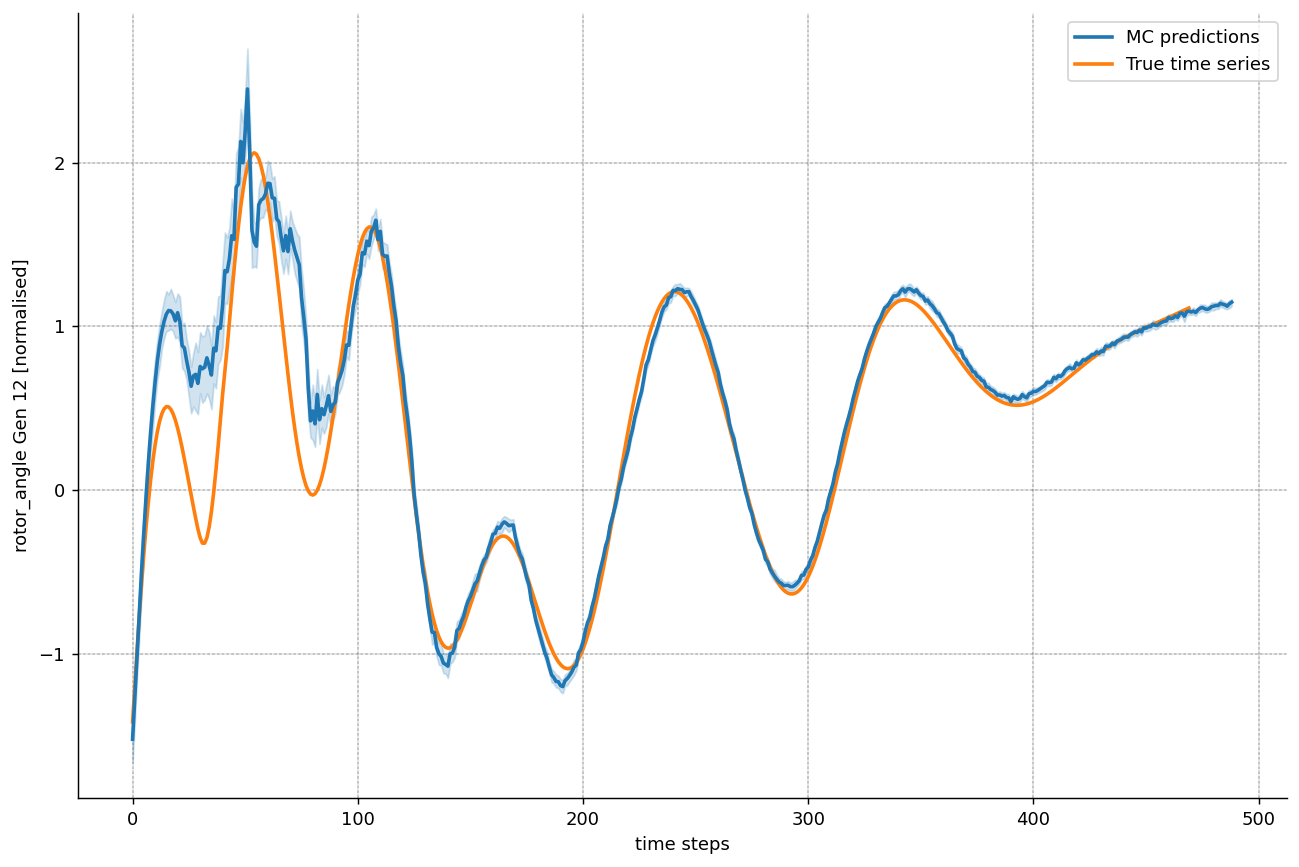

In [ ]:
plot_col = 'rotor_angle Gen 12'

fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

sns.lineplot(x='time_steps', y = forecasts_df.iloc[:,label_columns_indices[plot_col]], 
                 data = forecasts_df,
                 linewidth=2,
                 #color = 'orange',
                 ci=100, 
                label = 'MC predictions', zorder=10)
plt.plot(test_df[0, 30:, 45 +label_columns_indices[plot_col]], label="True time series", linewidth=2)
ax.set_xlabel('time steps')
plt.ylabel(f'{plot_col} [normalised]')
plt.grid(color='k', ls = '-.', lw = 0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()

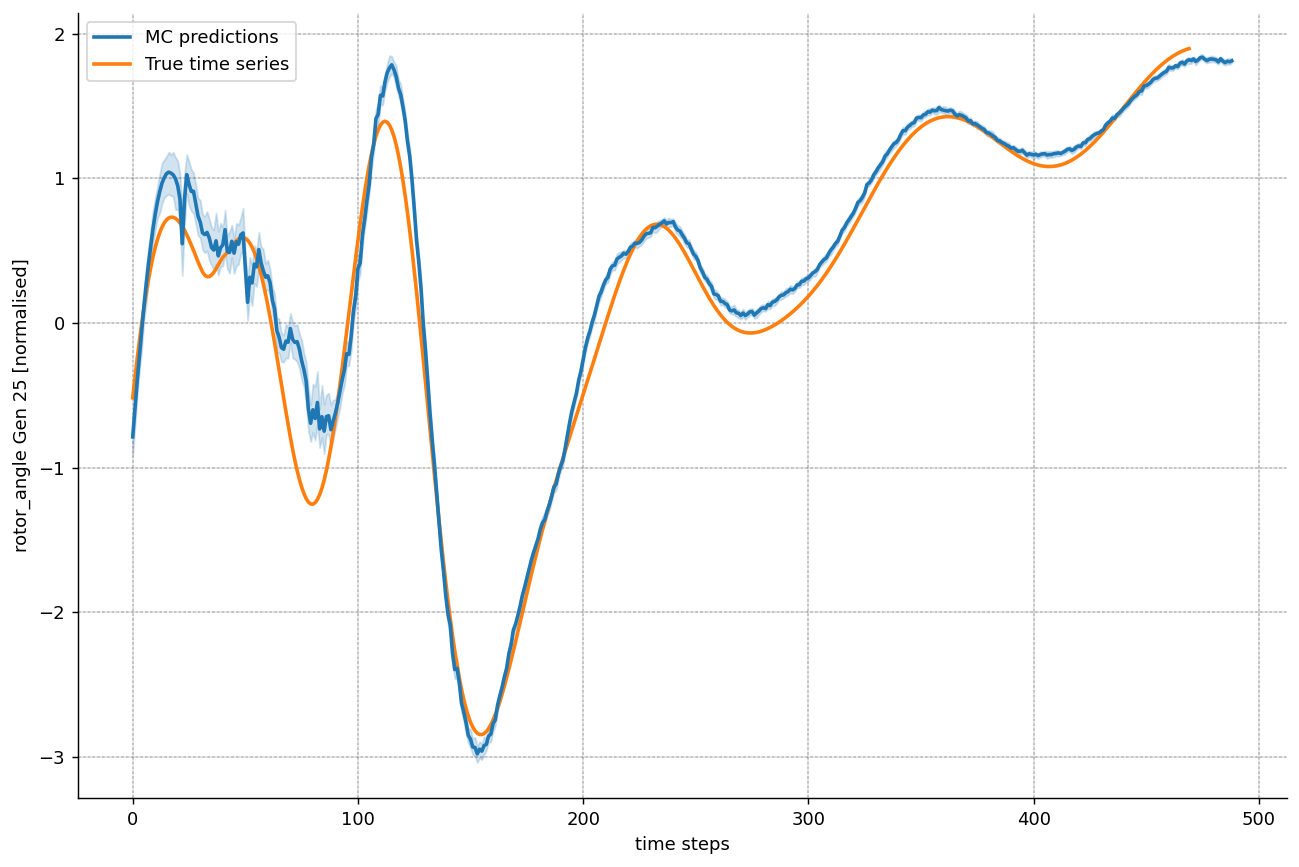

In [ ]:
plot_col = 'rotor_angle Gen 25'

fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

sns.lineplot(x='time_steps', y = forecasts_df.iloc[:,label_columns_indices[plot_col]], 
                 data = forecasts_df,
                 linewidth=2,
                 #color = 'orange',
                 ci=100, 
                label = 'MC predictions', zorder=10)
plt.plot(test_df[0, 30:, 45 +label_columns_indices[plot_col]], label="True time series", linewidth=2)
ax.set_xlabel('time steps')
plt.ylabel(f'{plot_col} [normalised]')
plt.grid(color='k', ls = '-.', lw = 0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()

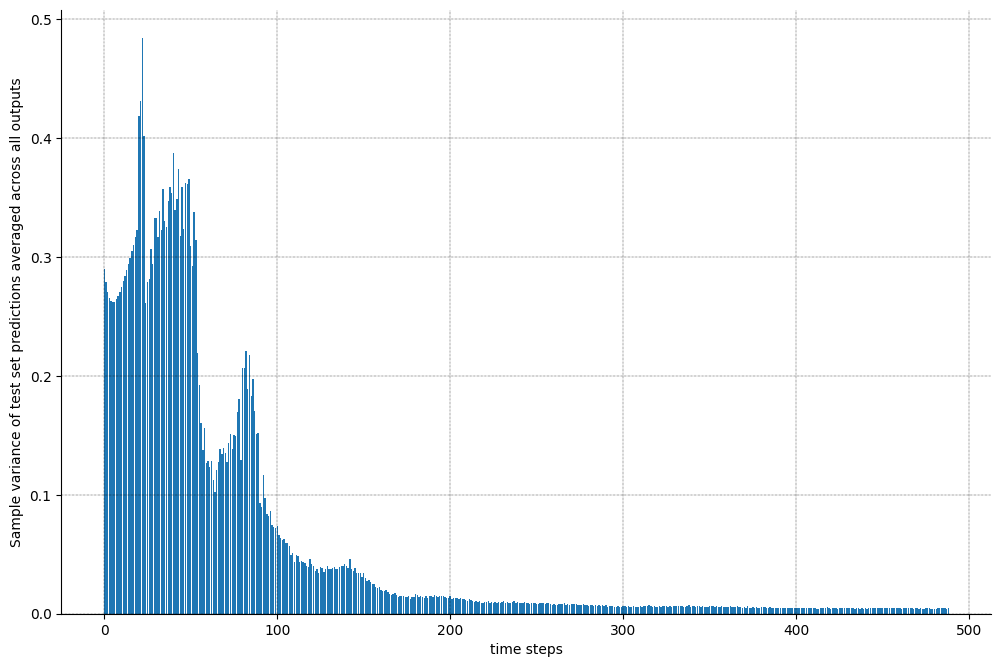

In [ ]:
x= np.arange(0, len(forecasts_var_mean))

fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

plt.bar(x, forecasts_var_mean)
ax.set_xlabel('time steps')
plt.ylabel('Sample variance of test set predictions averaged across all outputs')
plt.grid(color='k', ls = '-.', lw = 0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [ ]:
model_variance = forecasts_var_mean.mean()

In [ ]:
model_variance

0.05879643186926842

In [ ]:
## comparing with no dropout

In [ ]:
encoder_decoder = tf.keras.models.load_model(bin_path+'/encoder_decoder_best_2')

In [ ]:
forecasts = []

first = encoder_decoder.predict(test_df[0,0:0 + look_back, :45][np.newaxis])

for time in range(1, len(test_df[0]) - look_back):
  preds = encoder_decoder.predict(test_df[0,time:time + look_back, :45][np.newaxis])
  forecasts.append(preds[0, -1, :])

In [ ]:
preds = np.array(forecasts)
preds = np.vstack((first.reshape(20,14),preds))

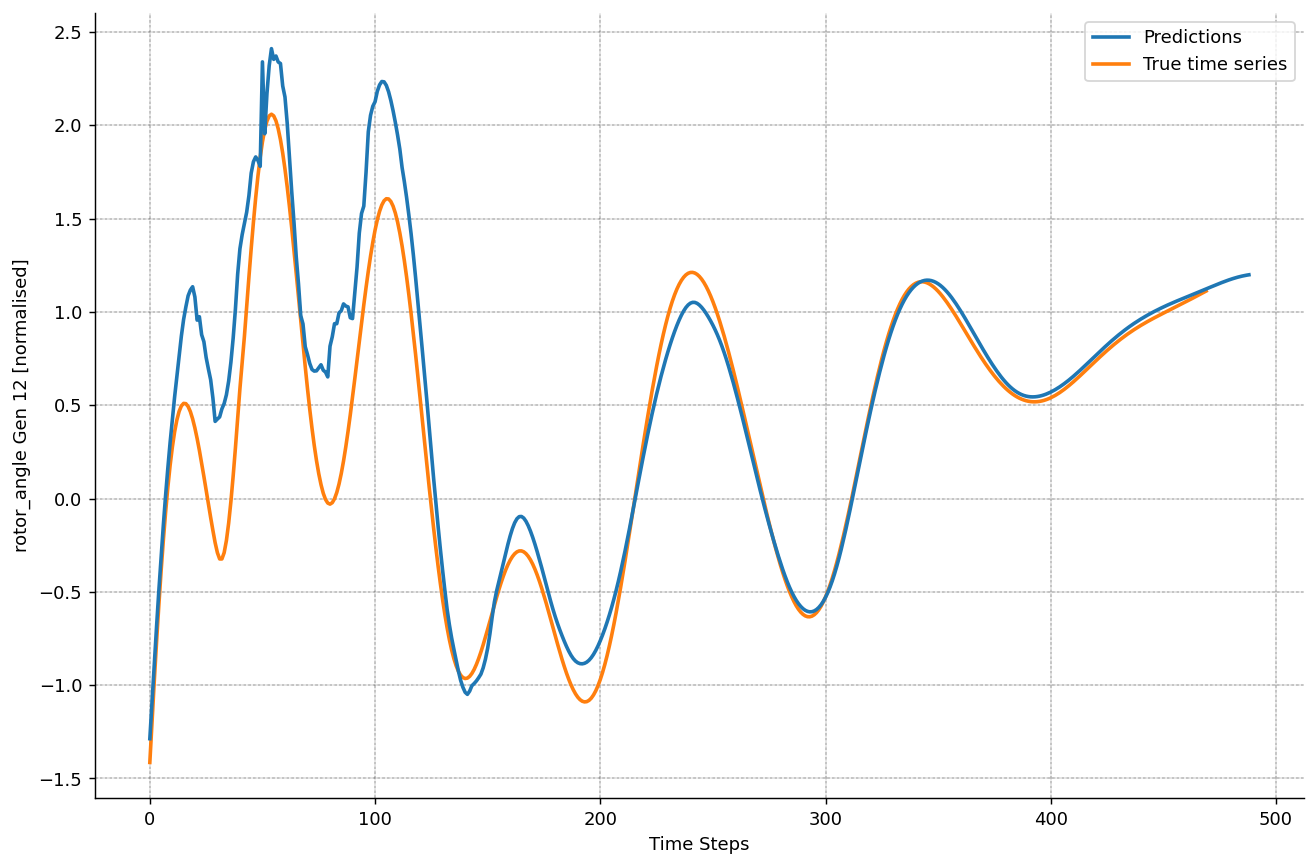

In [ ]:
plot_col = 'rotor_angle Gen 12'
fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

plt.plot(preds[:,label_columns_indices[plot_col]], label="Predictions", linewidth=2, zorder=10)
plt.plot(test_df[0, 30:, 45 +label_columns_indices[plot_col]], label="True time series", linewidth=2)
plt.grid(color='k', ls = '-.', lw = 0.25)
plt.legend()
plt.ylabel(f'{plot_col} [normalised]')
plt.xlabel('Time Steps')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

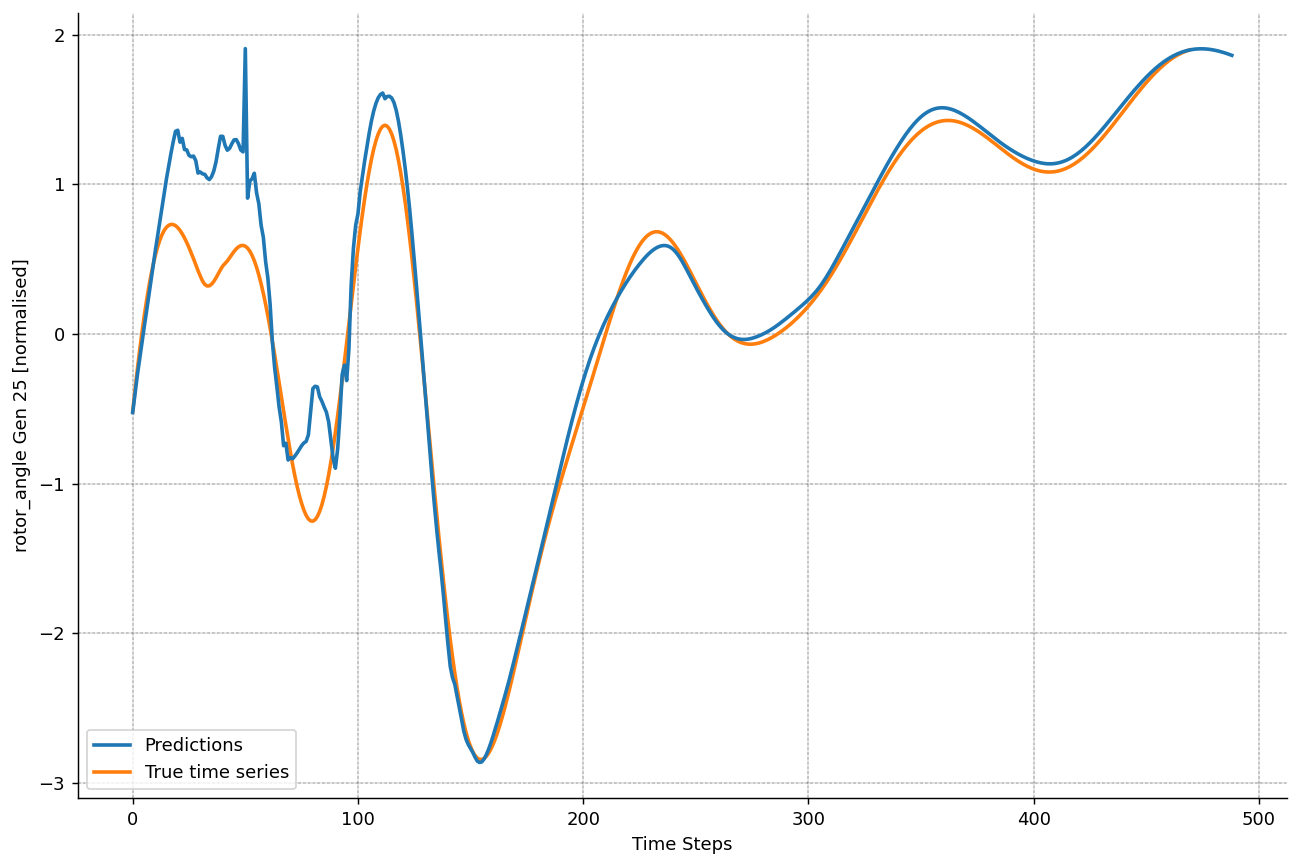

In [ ]:
plot_col = 'rotor_angle Gen 25'
fig, ax = plt.subplots(figsize=(12, 8), dpi=130)

plt.plot(preds[:,label_columns_indices[plot_col]], label="Predictions", linewidth=2, zorder=10)
plt.plot(test_df[0, 30:, 45 +label_columns_indices[plot_col]], label="True time series", linewidth=2)
plt.grid(color='k', ls = '-.', lw = 0.25)
plt.legend()
plt.ylabel(f'{plot_col} [normalised]')
plt.xlabel('Time Steps')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()